In [1]:
# 从 google.colab 库中导入 drive 模块
# 这个模块提供了与 Google Drive 交互的功能，例如挂载（mount）文件系统
from google.colab import drive
# 调用 drive 模块的 mount 方法将 Google Drive 挂载到 Colab 的虚拟机上
# '/content/gdrive' 是挂载的目标路径，挂载成功后，Google Drive 的内容将可以在此路径下访问
# 执行这行代码会弹出一个授权提示，需要用户登录 Google 账号并授权访问 Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# 随机森林分类分析 - 处理new_data.csv数据集

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns




plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [3]:
# ----------------------------
# 1. 加载数据集
# 本节代码负责从指定路径加载 'new_data.csv' 文件，并进行初步的数据检查，包括打印数据集的形状、前几行数据、基本信息以及缺失值统计。
# ----------------------------
try:
    # 读取CSV文件
    df = pd.read_csv('/content/gdrive/MyDrive/ElectricPowerTraining/data/new_data.csv')
    print("数据集加载成功！")
    print(f"数据集形状：{df.shape}（行：样本数，列：特征数）")
    print("\n数据集前5行预览：")
    print(df.head())

    # 检查数据集基本信息
    print("\n数据集基本信息：")
    print(df.info())

    # 检查缺失值
    missing_values = df.isnull().sum()
    print("\n缺失值统计：")
    print(missing_values[missing_values > 0])  # 只显示有缺失值的列

except FileNotFoundError:
    print("错误：未找到new_data.csv文件，请确保文件在当前工作目录下")
    exit()
except Exception as e:
    print(f"加载数据时发生错误：{str(e)}")
    exit()

数据集加载成功！
数据集形状：(75552, 15)（行：样本数，列：特征数）

数据集前5行预览：
   Unnamed: 0      value  weather_status  temperature  humidity  wind_speed  \
0           0  3210.8425             1.0        -8.60      41.0         0.5   
1           1  3104.5070             1.0        -8.88      43.0         0.5   
2           2  3037.7060             1.0        -9.16      45.0         0.5   
3           3  2960.1763             1.0        -9.44      47.0         0.5   
4           4  2889.2266             3.0        -9.70      49.0         0.7   

   wind_direction_angle  pressure  visibility  precipitation  light  holiday  \
0                 359.0     977.0         9.7            0.0    0.0      1.0   
1                 359.0     977.0         9.7            0.0    0.0      1.0   
2                 359.0     977.0         9.7            0.0    0.0      1.0   
3                 359.0     977.0         9.7            0.0    0.0      1.0   
4                 335.0     976.0         8.6            0.0    0.0      1

In [4]:
# ----------------------------
# 2. 数据预处理
# 本节代码进行数据预处理，包括：
# - 检查并指定目标变量（默认为 'weather_status'）。
# - 将数据集分为特征 (X) 和目标变量 (y)。
# - 对非数值特征进行 One-Hot 编码。
# - 使用列均值填充数值特征的缺失值。
# - 将数据集划分为训练集和测试集，并进行分层抽样以保持类别比例。
# ----------------------------
# 假设目标变量是'weather_status'（可根据实际情况修改）
target_column = 'weather_status'

# 检查目标变量是否存在
if target_column not in df.columns:
    print(f"\n错误：数据集中未找到目标变量列'{target_column}'")
    print("请修改代码中的'target_column'变量为实际的目标列名")
    exit()

# 分离特征和目标变量
X = df.drop(columns=[target_column])  # 特征
y = df[target_column]  # 目标变量

# 处理可能的非数值特征（如果有的话）
# 这里假设所有特征都是数值型，如有类别型特征需要进行编码
numeric_features = X.select_dtypes(include=['number']).columns
non_numeric_features = X.columns.difference(numeric_features)

if len(non_numeric_features) > 0:
    print(f"\n警告：检测到非数值特征，将进行One-Hot编码：{non_numeric_features.tolist()}")
    X = pd.get_dummies(X, columns=non_numeric_features)

# 处理缺失值（简单填充）
if df.isnull().sum().sum() > 0:
    print("\n处理缺失值：使用列均值填充数值特征")
    X = X.fillna(X.mean())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify确保分层抽样
)

print(f"\n数据集划分完成：")
print(f"训练集：{X_train.shape[0]}个样本，测试集：{X_test.shape[0]}个样本")


数据集划分完成：
训练集：52886个样本，测试集：22666个样本


In [5]:
# ----------------------------
# 3. 自定义随机森林分类器
# 本节定义了一个名为 `RandomForestClassifierCustom` 的自定义随机森林分类器类。
# - `__init__` 方法初始化分类器的参数，如树的数量和随机种子。
# - `fit` 方法实现随机森林的训练过程，包括 Bootstrap 抽样和构建多棵决策树。
# - `predict` 方法通过多数投票的方式聚合所有决策树的预测结果，从而得到最终预测标签。
# ----------------------------
class RandomForestClassifierCustom:
    """自定义随机森林分类器"""
    def __init__(self, n_estimators=100, random_state=0):
        self.n_estimators = n_estimators  # 树的数量
        self.random_state = random_state  # 随机种子
        self.trees = []  # 存储决策树集合

    def fit(self, X, y):
        """拟合数据集"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            # Bootstrap抽样（有放回）
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X.iloc[sample_indices] if isinstance(X, pd.DataFrame) else X[sample_indices]
            y_boot = y.iloc[sample_indices] if isinstance(y, pd.Series) else y[sample_indices]

            # 创建决策树
            tree = DecisionTreeClassifier(
                max_features="sqrt",  # 随机选择特征
                random_state=np.random.randint(1e6)
            )
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)

    def predict(self, X):
        """预测标签：多数投票"""
        # 转换为numpy数组以便处理
        if isinstance(X, pd.DataFrame):
            X = X.values

        # 收集所有树的预测结果
        predictions = np.array([tree.predict(X) for tree in self.trees])

        # 多数投票（按列取众数）
        def most_frequent(x):
            return np.bincount(x.astype(int)).argmax()

        return np.apply_along_axis(most_frequent, axis=0, arr=predictions)

In [6]:
# ----------------------------
# 4. 训练与评估模型
# 本节代码分别训练并评估自定义随机森林模型和 scikit-learn 的 `RandomForestClassifier` 模型。
# - 打印两个模型的准确率、混淆矩阵和分类报告，以便进行性能对比。
# ----------------------------
print("\n开始训练自定义随机森林模型...")
rf_custom = RandomForestClassifierCustom(n_estimators=100, random_state=42)
rf_custom.fit(X_train, y_train)

# 预测
y_pred_custom = rf_custom.predict(X_test)

# 评估自定义模型
print("\n===== 自定义随机森林模型评估 ===telek")
print(f"准确率 (Accuracy): {accuracy_score(y_test, y_pred_custom):.4f}")
print("\n混淆矩阵:")
cm_custom = confusion_matrix(y_test, y_pred_custom)
print(cm_custom)
print("\n分类报告:")
print(classification_report(y_test, y_pred_custom))

# 使用sklearn的随机森林进行对比
print("\n开始训练sklearn随机森林模型...")
rf_sklearn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sklearn.fit(X_train, y_train)

# 评估sklearn模型
y_pred_sklearn = rf_sklearn.predict(X_test)
print("\n===== sklearn随机森林模型评估 ===telek")
print(f"准确率 (Accuracy): {accuracy_score(y_test, y_pred_sklearn):.4f}")
print("\n混淆矩阵:")
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
print(cm_sklearn)
print("\n分类报告:")
print(classification_report(y_test, y_pred_sklearn))


开始训练自定义随机森林模型...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local


===== 自定义随机森林模型评估 ===telek
准确率 (Accuracy): 0.9855

混淆矩阵:
[[10531    25     5     0     0     0     3     0     0     0     1     0
      0     0     0]
 [   83  4433    26     0     0     0     2     0     0     0     2     0
      0     0     0]
 [   43    38  4273     3     0     0     3     0     0     0     3     1
      0     0     0]
 [   14     8    28   782     0     0     0     1     0     0     0     0
      0     0     0]
 [    0     0     6     3    68     0     0     0     0     0     0     0
      0     0     0]
 [    1     0     0     0     0    10     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   982     0     0     0     0     0
      0     0     0]
 [    0     0     4     0     0     0     0    37     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0     0     0     1     0     0     0
      0     0     0]
 [    0     1     0     0     0     0     0     0     0   166     0     0
      0     0

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from fon

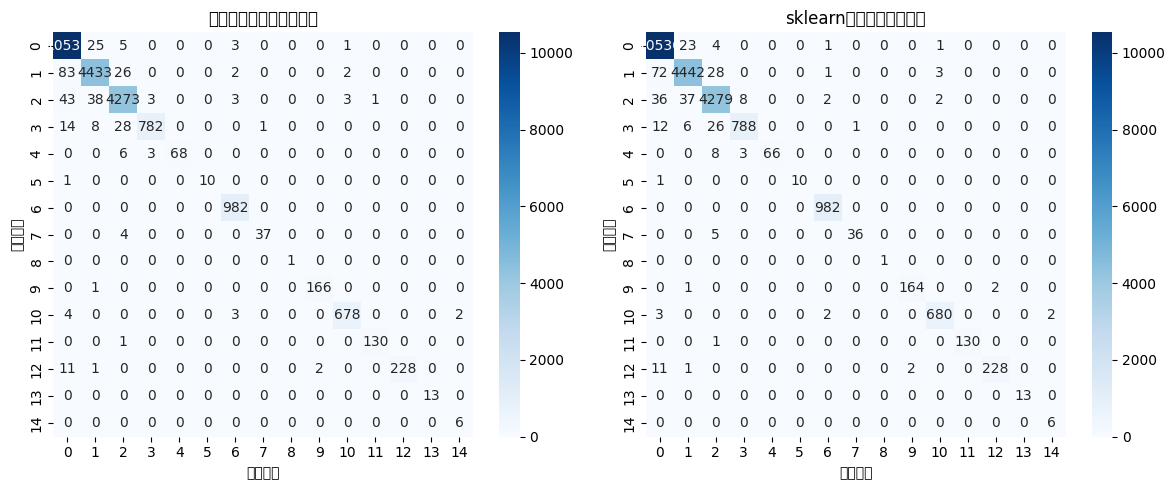

/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-3930194422.py:35: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAP

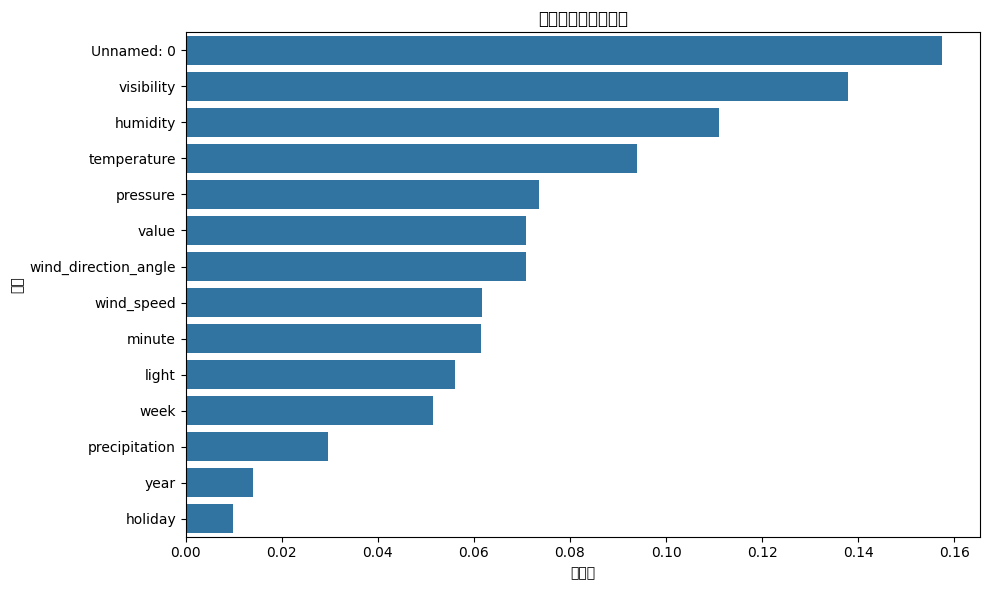


分析完成！


In [7]:
# ----------------------------
# 5. 可视化分析
# 本节代码负责生成模型的性能可视化。
# - 绘制自定义模型和 scikit-learn 模型的混淆矩阵热力图，直观展示分类结果。
# - 绘制 scikit-learn 模型（如果可用）的特征重要性条形图，显示各个特征对模型预测的贡献程度。
# ----------------------------
# 1. 混淆矩阵可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 自定义模型混淆矩阵
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('自定义随机森林混淆矩阵')
axes[0].set_xlabel('预测标签')
axes[0].set_ylabel('真实标签')

# sklearn模型混淆矩阵
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('sklearn随机森林混淆矩阵')
axes[1].set_xlabel('预测标签')
axes[1].set_ylabel('真实标签')

plt.tight_layout()
plt.show()

# 2. 特征重要性可视化（使用sklearn模型）
if hasattr(rf_sklearn, 'feature_importances_') and len(X.columns) > 0:
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        '特征': X.columns,
        '重要性': rf_sklearn.feature_importances_
    }).sort_values(by='重要性', ascending=False)

    sns.barplot(x='重要性', y='特征', data=feature_importance)
    plt.title('随机森林特征重要性')
    plt.tight_layout()
    plt.show()
else:
    print("\n无法生成特征重要性图：特征数量不足或模型不支持")

print("\n分析完成！")